# Gaussian Mixture

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `d:\OneDrive - TU Eindhoven\phd\Projects\Packages\RxInfer.jl\examples`

This notebook illustrates how to use the `NormalMixture` node in `RxInfer.jl` for both univariate and multivariate observations.

### Load packages

In [1]:
using RxInfer, Plots, Random, LinearAlgebra, StableRNGs, LaTeXStrings

## Univariate Gaussian Mixture Model

Consider the data set of length $N$ observed below.

In [2]:
function generate_univariate_data(nr_samples; rng = MersenneTwister(123))

    # data generating parameters
    class        = [1/3, 2/3]
    mean1, mean2 = -10, 10
    precision    = 1.777

    # generate data
    z = rand(rng, Categorical(class), nr_samples)
    y = zeros(nr_samples)
    for k in 1:nr_samples
        y[k] = rand(rng, Normal(z[k] == 1 ? mean1 : mean2, 1/sqrt(precision)))
    end

    return y

end;

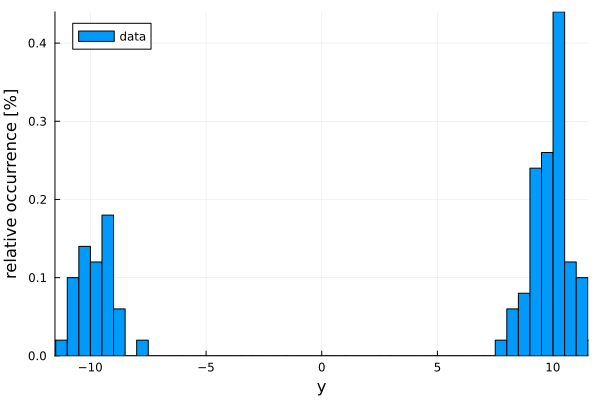

In [3]:
data_univariate = generate_univariate_data(100)
histogram(data_univariate, bins=50, label="data", normed=true)
xlims!(minimum(data_univariate), maximum(data_univariate))
ylims!(0, Inf)
ylabel!("relative occurrence [%]")
xlabel!("y")

### Model specification

The goal here is to create a model for the data set above. In this case a Gaussian mixture model with $K$ components seems to suite the situation well. We specify the factorized model as 
$$p(y, z, s, m, w) = \prod_{n=1}^N \bigg(p(y_n \mid m, w, z_n) p(z_n \mid s) \bigg)\prod_{k=1}^K \bigg(p(m_k) p(w_k) \bigg) p(s),$$
where the individual terms are specified as
$$\begin{aligned}
    p(s)                    &= \mathrm{Beta}(s \mid \alpha_s, \beta_s) \\
    p(m_{k})                &= \mathcal{N}(m_k \mid \mu_k, \sigma_k^2) \\    
    p(w_{k})                &= \Gamma(w_k \mid \alpha_k, \beta_k) \\
    p(z_n \mid s)           &= \mathrm{Ber}(z_n \mid s) \\
    p(y_n \mid m, w, z_n)   &= \prod_{k=1}^K \mathcal{N}\left(y_n \mid m_{k}, w_{k}\right)^{z_{nk}}
\end{aligned}$$

The set of observations $y = \{y_1, y_2, \ldots, y_N\}$ is modeled by a mixture of Gaussian distributions, parameterized by means $m = \{m_1, m_2, \ldots, m_K\}$ and precisions $w = \{ w_1, w_2, \ldots, w_K\}$, where $k$ denotes the component index. This component is selected per observation by the indicator variable $z_n$, which is a one-of-$K$ encoded vector satisfying $\sum_{k=1}^K z_{nk} = 1$ and $z_{nk} \in \{0, 1\} \forall k$. We put a hyperprior on these variables, termed $s$, which represents the relative occurrence of the different realizations of $z_n$.

Here we implement the following model with uninformative values for the hyperparameters as

In [4]:
@model function univariate_gaussian_mixture_model(nr_samples)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ Normal(mean = -2.0, var = 1e3)
    w1 ~ Gamma(shape = 0.01, rate = 0.01)
    
    m2 ~ Normal(mean = 2.0, var = 1e3)
    w2 ~ Gamma(shape = 0.01, rate = 0.01)
    
    z = randomvar(nr_samples)
    y = datavar(Float64, nr_samples)
    
    for n in 1:nr_samples
        z[n] ~ Bernoulli(s)
        y[n] ~ NormalMixture(z[n], (m1, m2), (w1, w2))
    end
    
end

### Probabilistic inference

In order to fit the model to the data, we are interested in computing the posterior distribution $p(z, s, m, w \mid y)$ However, computation of this term is intractable. Therefore, it is approximated by a naive mean-field approximation, specified as 
$$p(z, s, m, w \mid y) \approx \prod_{n=1}^N q(z_n) \prod_{k=1}^K \bigg(q(m_k) q(w_k)\bigg) q(s),$$
with the functional forms
$$\begin{aligned}
    q(s)   &= \mathrm{Beta}(s \mid \hat{\alpha}_s, \hat{\beta}_s) \\
    q(m_k) &= \mathcal{N}(m_k \mid \hat{\mu}_k, \hat{\sigma}^2_k) \\
    q(w_k) &= \Gamma (w_k \mid \hat{\alpha}_k, \hat{\beta}_k) \\
    q(z_n) &= \mathrm{Ber}(z_n \mid \hat{p}_n)
\end{aligned}$$
In order to get the inference procedure started, these marginal distribution need to be initialized.

In [5]:
results_univariate = infer(
    model = univariate_gaussian_mixture_model(length(data_univariate)), 
    constraints = MeanField(),
    data  = (y = data_univariate,), 
    initmarginals = (
        s  = vague(Beta), 
        m1 = NormalMeanVariance(-2.0, 1e3), 
        m2 = NormalMeanVariance(2.0, 1e3), 
        w1 = vague(GammaShapeRate), 
        w2 = vague(GammaShapeRate)
    ), 
    iterations  = 10, 
    free_energy = true
)

Inference results:
  Posteriors       | available for (m2, m1, s, w2, w1, z)
  Free Energy:     | Real[360.857, 226.858, 161.566, 135.301, 135.277, 135.277, 135.277, 135.277, 135.277, 135.277]


### Results

Below the inference results can be seen as a function of the iterations

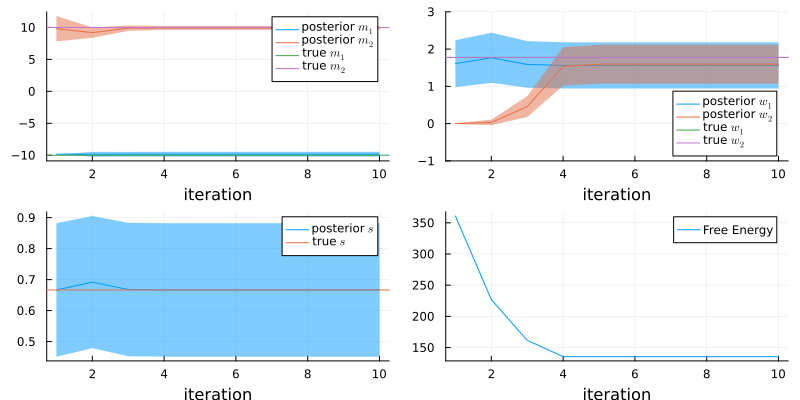

In [6]:
mp = plot(mean.(results_univariate.posteriors[:m1]), ribbon = std.(results_univariate.posteriors[:m1]) .|> sqrt, label = L"posterior $m_1$")
mp = plot!(mean.(results_univariate.posteriors[:m2]), ribbon = std.(results_univariate.posteriors[:m2]) .|> sqrt, label = L"posterior $m_2$")
mp = plot!(mp, [ -10 ], seriestype = :hline, label = L"true $m_1$")
mp = plot!(mp, [ 10 ], seriestype = :hline, label = L"true $m_2$")

wp = plot(mean.(results_univariate.posteriors[:w1]), ribbon = std.(results_univariate.posteriors[:w1]) .|> sqrt, label = L"posterior $w_1$", legend = :bottomright, ylim = (-1, 3))
wp = plot!(wp, mean.(results_univariate.posteriors[:w2]), ribbon = std.(results_univariate.posteriors[:w2]) .|> sqrt, label = L"posterior $w_2$")
wp = plot!(wp, [ 1.777 ], seriestype = :hline, label = L"true $w_1$")
wp = plot!(wp, [ 1.777 ], seriestype = :hline, label = L"true $w_2$")

swp = plot(mean.(results_univariate.posteriors[:s]), ribbon = std.(results_univariate.posteriors[:s]) .|> sqrt, label = L"posterior $s$")
swp = plot!(swp, [ 2/3 ], seriestype = :hline, label = L"true $s$")

fep = plot(results_univariate.free_energy, label = "Free Energy", legend = :topright)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (800, 400))
xlabel!("iteration")

## Multivariate Gaussian Mixture Model

The above example can also be extended to the multivariate case. Consider the data set below

In [7]:
function generate_multivariate_data(nr_samples; rng = MersenneTwister(123))

    L         = 50.0
    nr_mixtures = 6

    probvec = normalize!(ones(nr_mixtures), 1)

    switch = Categorical(probvec)

    gaussians = map(1:nr_mixtures) do index
        angle      = 2π / nr_mixtures * (index - 1)
        basis_v    = L * [ 1.0, 0.0 ]
        R          = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
        mean       = R * basis_v 
        covariance = Matrix(Hermitian(R * [ 10.0 0.0; 0.0 20.0 ] * transpose(R)))
        return MvNormal(mean, covariance)
    end

    z = rand(rng, switch, nr_samples)
    y = Vector{Vector{Float64}}(undef, nr_samples)

    for n in 1:nr_samples
        y[n] = rand(rng, gaussians[z[n]])
    end

    return y

end;

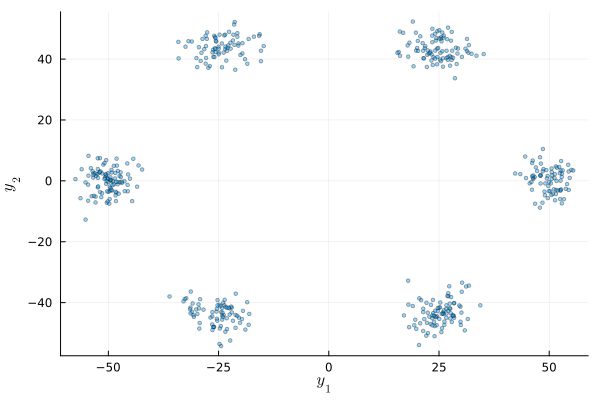

In [8]:
data_multivariate = generate_multivariate_data(500)

sdim(n) = (a) -> map(d -> d[n], a) # helper function
scatter(data_multivariate |> sdim(1), data_multivariate |> sdim(2), ms = 2, alpha = 0.4, size = (600, 400), legend=false)
xlabel!(L"y_1")
ylabel!(L"y_2")

### Model specification

The goal here is to create a model for the data set above. In this case a Gaussian mixture model with $K$ components seems to suite the situation well. We specify the factorized model as 
$$p(y, z, s, m, w) = \prod_{n=1}^N \bigg(p(y_n \mid m, W, z_n) p(z_n \mid s) \bigg)\prod_{k=1}^K \bigg(p(m_k) p(W_k) \bigg) p(s),$$
where the individual terms are specified as
$$\begin{aligned}
    p(s)                    &= \mathrm{Dir}(s \mid \alpha_s) \\
    p(m_{k})                &= \mathcal{N}(m_k \mid \mu_k, \Sigma_k) \\    
    p(W_{k})                &= \mathcal{W}(W_k \mid V_k, \nu_k) \\
    p(z_n \mid s)           &= \mathrm{Cat}(z_n \mid s) \\
    p(y_n \mid m, W, z_n)   &= \prod_{k=1}^K \mathcal{N}\left(y_n \mid m_{k}, W_{k}\right)^{z_{nk}}
\end{aligned}$$

The set of observations $y = \{y_1, y_2, \ldots, y_N\}$ is modeled by a mixture of Gaussian distributions, parameterized by means $m = \{m_1, m_2, \ldots, m_K\}$ and precisions $W = \{ W_1, W_2, \ldots, W_K\}$, where $k$ denotes the component index. This component is selected per observation by the indicator variable $z_n$, which is a one-of-$K$ encoded vector satisfying $\sum_{k=1}^K z_{nk} = 1$ and $z_{nk} \in \{0, 1\} \forall k$. We put a hyperprior on these variables, termed $s$, which represents the relative occurrence of the different realizations of $z_n$.

In [9]:
@model function multivariate_gaussian_mixture_model(nr_mixtures, nr_samples, priors_mean, priors_cov)
    
    z = randomvar(nr_samples)
    m = randomvar(nr_mixtures)
    w = randomvar(nr_mixtures)
    y = datavar(Vector{Float64}, nr_samples)
    
    for k in 1:nr_mixtures        
        m[k] ~ MvNormal(μ = priors_mean[k], Σ = priors_cov[k])
        w[k] ~ Wishart(3, 1e2*diagm(ones(2)))
    end
    
    s ~ Dirichlet(ones(nr_mixtures))
    
    means = tuple(m...)
    precs = tuple(w...)
    
    for n in 1:nr_samples
        z[n] ~ Categorical(s) 
        y[n] ~ NormalMixture(z[n], means, precs)
    end
    
end

### Probabilistic inference

In order to fit the model to the data, we are interested in computing the posterior distribution $p(z, s, m, W \mid y)$ However, computation of this term is intractable. Therefore, it is approximated by a naive mean-field approximation, specified as 
$$p(z, s, m, W \mid y) \approx \prod_{n=1}^N q(z_n) \prod_{k=1}^K \bigg(q(m_k) q(W_k)\bigg) q(s),$$
with the functional forms
$$\begin{aligned}
    q(s)   &= \mathrm{Dir}(s \mid \hat{\alpha}_s) \\
    q(m_k) &= \mathcal{N}(m_k \mid \hat{\mu}_k, \hat{\Sigma}_k) \\
    q(w_k) &= \mathcal{W}(W_k \mid \hat{V}_k, \hat{\nu}_k) \\
    q(z_n) &= \mathrm{Cat}(z_n \mid \hat{p}_n)
\end{aligned}$$
In order to get the inference procedure started, these marginal distribution need to be initialized.

In [10]:
rng = MersenneTwister(121)
m = [[cos(k*2π/6), sin(k*2π/6)] for k in 1:6]
results_multivariate = infer(
    model = multivariate_gaussian_mixture_model(
        6, 
        length(data_multivariate), 
        m,
        [diagm(1e2 * ones(2)) for k in 1:6]
    ), 
    data  = (y = data_multivariate,), 
    constraints   = MeanField(),
    initmarginals = (
        s = vague(Dirichlet, 6), 
        m = [MvNormalMeanCovariance(m[k], diagm(1e2 * ones(2))) for k in 1:6], 
        w = Wishart(3, diagm(1e2 * ones(2)))
    ), 
    iterations  = 50, 
    free_energy = true
)

Inference results:
  Posteriors       | available for (m, w, s, z)
  Free Energy:     | Real[4166.93, 4025.27, 3908.18, 3894.5, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49  …  3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49, 3894.49]


### Results
Below the inference results can be seen

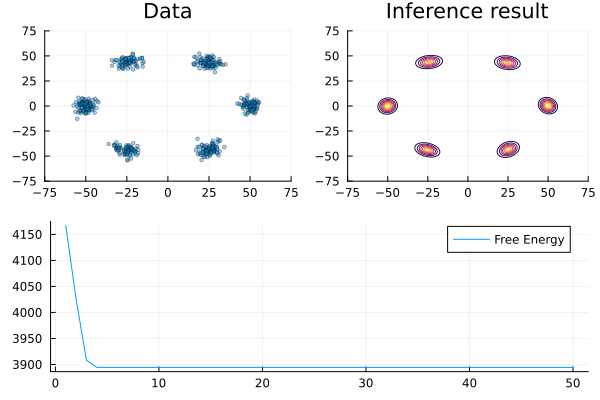

In [12]:
p_data = scatter(data_multivariate |> sdim(1), data_multivariate |> sdim(2), ms = 2, alpha = 0.4, legend=false, title="Data", xlims=(-75, 75), ylims=(-75, 75))
p_result = plot(xlims = (-75, 75), ylims = (-75, 75), title="Inference result", legend=false, colorbar = false)
for (e_m, e_w) in zip(results_multivariate.posteriors[:m][end], results_multivariate.posteriors[:w][end])
    gaussian = MvNormal(mean(e_m), Matrix(Hermitian(mean(inv, e_w))))
    global p_result = contour!(p_result, range(-75, 75, step = 0.25), range(-75, 75, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), title="Inference result", legend=false, levels = 7, colorbar = false)
end
p_fe = plot(results_multivariate.free_energy, label = "Free Energy")

plot(p_data, p_result, p_fe, layout = @layout([ a b; c ]))
